In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import IGate
from qiskit_aer.noise import NoiseModel, pauli_error
import numpy as np
import matplotlib.pyplot as plt
shots=1024

#service=QiskitRuntimeService()
noise=NoiseModel()
p_e=.1
bitflip_error=pauli_error([('X', p_e), ('I', 1-p_e)])
#cx_error=bitflip_error.tensor(bitflip_error)

noise.add_all_qubit_quantum_error(bitflip_error, [r'$\epsilon$'])
#noise.add_all_qubit_quantum_error(cx_error, ['cx'])

backend=AerSimulator(noise_model=noise)

#backend=service.least_busy(5,)
sampler=Sampler(mode=backend)
#psi=QuantumRegister(1, name=r'|{\psi}\rangle')
data=QuantumRegister(3, name='data')
ancilla=QuantumRegister(2, name='ancilla')
syndrome=ClassicalRegister(2, name='syndrome')
meas=ClassicalRegister(3, name='readout')

def hamming_weight(x:int):
    return x.bit_count()
def decode(encoded_message):
    encoded_message_hamming_weight=hamming_weight(int(encoded_message,base=2))
    majority=len(encoded_message)/2 
    #Simple majority rule decoding
    if encoded_message_hamming_weight>majority: return '1' 
    else: return '0'

def repetition_code_w_correction(data: QuantumRegister, ancilla: QuantumRegister, 
                                 syndrome: ClassicalRegister, meas: ClassicalRegister, cycles=1):
        qc= QuantumCircuit(data, ancilla, syndrome, meas) #QuantumCircuit(psi, ancilla, meas)
        #qc.reset(ancilla)
        qc.reset(data[1:])
        qc.barrier(data)
        qc.cx(data[0], data[1])
        qc.cx(data[0], data[2])
        qc.barrier()
        for _ in range(cycles):
            qc.unitary(IGate(), data, label=r'$\epsilon$')

            qc.barrier()
            qc.cx(data[0], ancilla[0])
            qc.cx(data[1], ancilla[0])
            qc.cx(data[0], ancilla[1])
            qc.cx(data[2], ancilla[1])

            qc.barrier()
            qc.measure(ancilla, syndrome)
            with qc.if_test((syndrome[0], 1)): qc.x(ancilla[0])
            with qc.if_test((syndrome[1], 1)): qc.x(ancilla[1])

            with qc.if_test((syndrome, 3)): qc.x(data[0])
            with qc.if_test((syndrome, 2)): qc.x(data[2])
            with qc.if_test((syndrome, 1)): qc.x(data[1])

        qc.barrier()
        qc.measure(data, meas)
        return qc

def test_qc(qc):
    result=sampler.run([qc], shots=shots).result()[0]
    counts=result.data['readout'].get_counts()
    good_trials=0
    for num, bin_str in zip(counts.values(), counts.keys()):
        if decode(bin_str)=='0': good_trials+=num
    return (good_trials/shots)

#survival_corrected=[]
# for j in range(10):
qc= QuantumCircuit(data, ancilla, syndrome, meas)
qc.h(data[0])
#qc.z(data[0])
circuit=repetition_code_w_correction(data, ancilla, syndrome, meas, 1)
qc=qc.compose(circuit)
result=test_qc(qc)
#survival_corrected.append(result)
result

0.49609375

In [19]:
result=sampler.run([qc], shots=shots).result()[0]
counting=result.data['readout'].get_counts()
counting

{'111': 510, '000': 514}

In [ ]:
qreg=QuantumRegister(1, 'psi')
creg=ClassicalRegister(1, 'readout')
survival_unprotected=[]

def unprotected_circuit(qreg, creg, cycles=1):
    qc=QuantumCircuit(qreg, creg)

    for _ in range(cycles): qc.unitary(IGate(), qreg, label=r'$\epsilon$')
    qc.measure(qreg, creg)
    return qc
for j in range(10):
    circuit=unprotected_circuit(qreg,creg, j)
    result=test_qc(circuit)
    survival_unprotected.append(result)

In [ ]:
qreg=QuantumRegister(3, 'data')
creg=ClassicalRegister(3, 'readout')
def repetition_code_wo_correction(qreg, creg, cycles=1):
    qc=QuantumCircuit(qreg, creg)
    qc.cx(qreg[0], qreg[1])
    qc.cx(qreg[0], qreg[2])
    for _ in range(cycles): qc.unitary(IGate(), qreg, label=r'$\epsilon$')
    qc.measure(qreg, creg)
    return qc

survival_uncorrected=[]
for j in range(10): 
    circuit=repetition_code_wo_correction(qreg, creg, j)
    result=test_qc(circuit)
    survival_uncorrected.append(result)

([<matplotlib.axis.XTick at 0x7175306c2ed0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

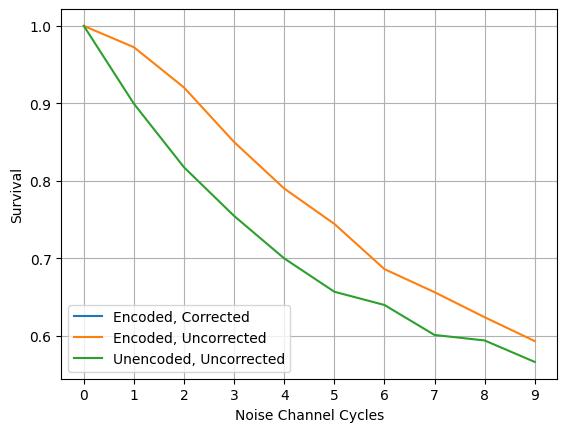

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(survival_corrected, label='Encoded, Corrected')    
plt.plot(survival_uncorrected, label='Encoded, Uncorrected')
plt.plot(survival_unprotected, label='Unencoded, Uncorrected')
plt.ylabel('Survival')
plt.legend(loc='lower left')
plt.xlabel(r'Noise Channel Cycles')
plt.grid(True)
plt.xticks(np.arange(10, step=1))

# A Large Issue 
$$H|000\rangle \rightarrow \frac{1}{\sqrt{2}}\left(|000\rangle + |111\rangle\right)\equiv |\Psi\rangle$$
$$